In [1]:
print("restsarast")

restsarast


In [2]:
import xarray as xr
import numba
import matplotlib.pyplot as plt
from Algorithms.fetchfields import *
from Algorithms.HelicopterTriggerIndex import *

In [3]:
ds = xr.open_dataset("http://thredds.met.no/thredds/dodsC/meps25epsarchive/2019/12/09/meps_extracted_2_5km_20191209T06Z.nc",engine="netcdf4")
ds1 = xr.open_dataset("https://thredds.met.no/thredds/dodsC/mepsarchive/2019/12/09/cmeps_det_2_5km_20191209T06Z.nc")
#ds = ds.isel(x = range(10,879),y = range(10,939))
HTI = xr.open_dataset("source/MEPS/meps_mbr0_pp_2_5km_20191209T06Z.nc")["helicopter_triggered_index"]
HTI1 = xr.open_dataset("source/MEPS/cmeps_det_thunder_2_5km_20191209T06Z.nc")["helicopter_triggered_index"]


In [4]:
ds = ds.isel(x = range(10,879),y = range(10,939)).sel(ensemble_member=0)

In [ ]:
ds.to_netcdf("source/MEPS/meps_mbr0_extracted_2_5km_20191209T06Z.nc")

In [4]:
HTIat10Local = HTI.isel(time=3)
HTI1at10Local = HTI1.isel(time=3)

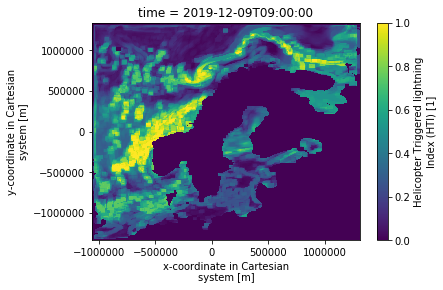

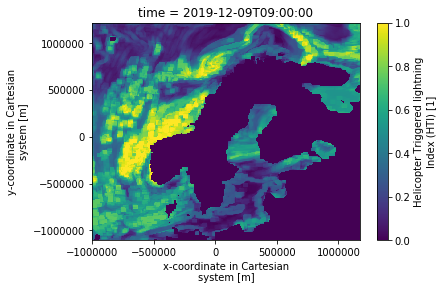

In [5]:
HTI1at10Local.plot()
plt.figure()
HTIat10Local.plot()

In [6]:
ds["upward_air_velocity_pl"].pressure.values

array([  50.,  100.,  150.,  200.,  250.,  300.,  400.,  500.,  700.,
        800.,  850.,  925., 1000.], dtype=float32)

In [7]:
geo_pl, geo_sf, airtemp_pl, rhs_pl, upward_pl, lowcloud, prec = fetchfields(ds,3)

In [8]:
from math import ceil,floor
@numba.jit
def neighbourhood_min(xarrayvalues,neigbhoursize = 3):
    N = neigbhoursize
    down,up = floor(N/2),ceil(N/2)
    # Assume incoming object to be numpy array
    X,Y = xarrayvalues.shape
    result = np.zeros((X,Y))
    # First fill non-trivial parts
    for y in range(down,Y-up+1):
        for x in range(down,X-up+1):
            result[x,y] = np.min(xarrayvalues[x-down:x+up,y-down:y+up])
    for i in range(down):
        for y in range(Y):
            result[i,y] = xarrayvalues[i,y]
            result[-(1+i),y] = xarrayvalues[-(1+i),y]
        for x in range(X):
            result[x,i] = xarrayvalues[x,i]
            result[x,-(1+i)] = xarrayvalues[x,-(1+i)]

    return result

In [9]:
def get_height_value_from_pl(geopotential_pl,variable_pl,height=750):
    # Assume 925 to 850 band always has interesting heights. May need changing later
    # Also Assume 9.81 is correct gravitational constant ( should be to 1%)
    variableperheight = (variable_pl.sel(pressure=850) - variable_pl.sel(pressure=925))/((geopotential_pl.sel(pressure=850) - geopotential_pl.sel(pressure=925))/9.81)
    result = variable_pl.sel(pressure=925) + variableperheight*(height -  geopotential_pl.sel(pressure=925)/9.81)
    return result

    

In [10]:
@numba.jit
def neighbourhood_max(xarrayvalues,neigbhoursize = 3):
    N = neigbhoursize
    down,up = floor(N/2),ceil(N/2)
    # Assume incoming object to be numpy array
    X,Y = xarrayvalues.shape
    result = np.zeros((X,Y))
    # First fill non-trivial parts
    for y in range(down,Y-up+1):
        for x in range(down,X-up+1):
            result[x,y] = np.max(xarrayvalues[x-down:x+up,y-down:y+up])
    for i in range(down):
        for y in range(Y):
            result[i,y] = xarrayvalues[i,y]
            result[-(1+i),y] = xarrayvalues[-(1+i),y]
        for x in range(X):
            result[x,i] = xarrayvalues[x,i]
            result[x,-(1+i)] = xarrayvalues[x,-(1+i)]

    return result


In [11]:
def only_positive_but_no_larger_than_1(array):
    size = array.shape
    result = np.zeros(size)
    result[np.where(array > 0)] = np.minimum(1.5*array[np.where(array>0)],1)
    return result

def only_positive_but_no_larger_than_1_with_scaling(topoarray):
    def f(array):
        size = array.shape
        result = np.zeros(size)
        result[np.where(array > 0) and np.where(topoarray < 10)] = np.minimum(1.5*array[np.where(array>0) and np.where(topoarray < 10)],1)
        skal = 1-(topoarray[np.where(array>0) and np.where(topoarray>10)]/15000)
        result[np.where(array > 0) and np.where(topoarray > 10)] = np.minimum(skal*1.5*array[np.where(array > 0) and np.where(topoarray > 10)],1)
        return result
    return f

In [67]:
air_temp = get_height_value_from_pl(geo_pl,airtemp_pl-273.15)

In [68]:
Nbh = 14

W_ = get_height_value_from_pl(geo_pl,upward_pl)
W = np.zeros_like(W_)
cl = np.zeros_like(lowcloud.values[0,...])
pc = np.zeros_like(prec.values[0,...])

for member in W_["ensemble_member"]:
    W[member] = neighbourhood_max(W_.isel(ensemble_member=member).values,Nbh)
    cl[member] = neighbourhood_max(lowcloud.isel(ensemble_member=member).values[0,...],Nbh)
    cl[member] -= neighbourhood_min(lowcloud.isel(ensemble_member=member).values[0,...],Nbh)
    pc[member] = neighbourhood_max(prec.isel(ensemble_member=member).values[0,...],Nbh)
W[np.where(W < 0)] = 0

In [70]:
print(W.shape)
print(cl.shape)
print(pc.shape)
print(air_temp.shape)

(10, 949, 889)
(10, 949, 889)
(10, 949, 889)
(10, 949, 889)


In [71]:
topomin = np.zeros_like(W)
topomax = np.zeros_like(topomin)
for member in geo_sf["ensemble_member"]:
    topomax[member] = neighbourhood_max(geo_sf.isel(ensemble_member=member).values[0,...],Nbh)
    topomin[member] = neighbourhood_min(geo_sf.isel(ensemble_member=member).values[0,...],Nbh)

In [72]:
np.max(topomax)

19876.990234375

In [86]:
tfunc = temperature_max_band_from_b_to_c(-1,-6)
wfunc = only_positive_but_no_larger_than_1#_with_scaling(topomax)
pfunc = only_positive_but_no_larger_than_1
cfunc = lambda x: x

In [87]:
HTI = HelicopterTriggerIndex([tfunc,wfunc,pfunc,cfunc])
result = HTI([air_temp.values,W,pc,cl])


In [88]:
result[np.where(topomin > 10)] = 0
result[np.where(topomax > 7500)] = 0


In [89]:
new_ds=ds.assign(HTI=(("ensemble_member","y","x"),result))

In [90]:
print(HTIat10Local["x"].shape,new_ds["x"].shape,ds["x"].shape)
print(HTIat10Local["y"].shape,new_ds["y"].shape,ds["y"].shape)

(869,) (889,) (889,)
(929,) (949,) (949,)


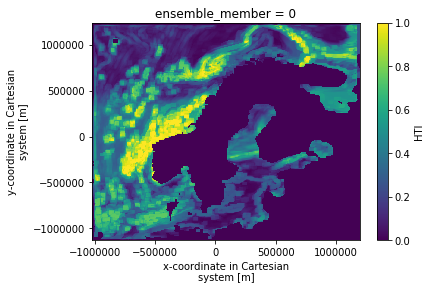

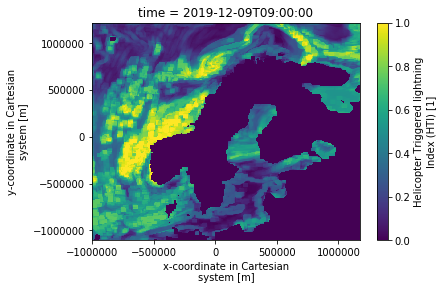

In [91]:
new_ds["HTI"].sel(ensemble_member=0).plot()
plt.figure()
HTIat10Local.plot()

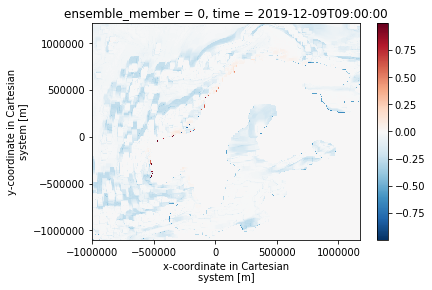

In [92]:
(new_ds["HTI"].sel(ensemble_member=0)-HTIat10Local ).plot()

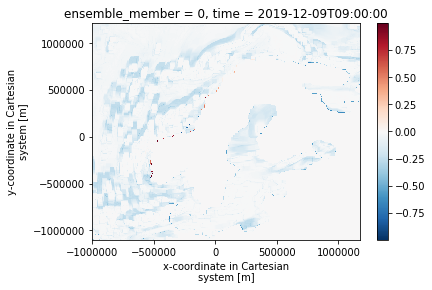

In [85]:
(new_ds["HTI"].sel(ensemble_member=0)-HTIat10Local ).plot()